<center>
    <h1 style="color:deeppink">Just between us SQL Friends...</h1>
    <h2 style="color:deeppink">RuPaul's Drag Race: Visualized</h2>
    <img src="media/header.gif" height="100px">
</center>

<h2 style="color:deeppink">Import Libraries & Connect SQLite Database</h2>

In [104]:
import pandas as pd
import sqlite3
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

drag_race_data_base = sqlite3.connect("drag_race_data.db")

<h2 style="color:deeppink">Define Constants, Global Variables, and API endpoints</h2>

In [105]:
DRAG_RACE_API_URL = "http://www.nokeynoshade.party/api/"

#API Endpoints
SEASONS = "seasons"
QUEENS = "queens/all"
SEASON_BY_NUMBER = "seasons/{}"

CHALLENGES_BY_QUEEN_ID = "queens/{}/challenges"
ALL_CHALLENGES = "challenges"
CHALLENGE_BY_NUMBER = "challenges/{}"



<h2 style="color:deeppink">Define Functions</h2>

In [106]:
#some, not all, api endpoints require a season_id number... we'll make that argument optional.
def get_data(endpoint, SEASON = None):
    data = pd.read_json(DRAG_RACE_API_URL + endpoint.format(SEASON))
    return data


def get_seasons():
    df = pd.DataFrame()
    temp_df = pd.DataFrame()
    for i in range(len(season_id_df)):
        temp_df = get_data("seasons/{}", i)
        temp_df = json_normalize(temp_df['queens'])
        temp_df['season_id'] = i + 1
        df = pd.concat([df, temp_df], sort=False)
        i += 1
    return df

def get_challenges():
    df = pd.DataFrame()
    temp_df = pd.DataFrame
    for i in range(10):
        temp_df = get_data(CHALLENGE_BY_NUMBER, i + 1)
        temp_df = json_normalize(temp_df['queens'])
        temp_df['challenge_number'] = i + 1
        df = pd.concat([df, temp_df], sort=False)
        i += 1
    return df

def csv_export(df, file_name):
    df.to_csv(file_name, index=True)

<h2 style="color:deeppink">Define SQL Queries</h2>

In [107]:
SELECT_QUEENS = """
    SELECT queens.id, name, season_number, place, winner, missCongeniality AS miss_congeniality, image_url, quote FROM seasons
    INNER JOIN season_ids ON seasons.season_id = season_ids.season_id
    INNER JOIN queens ON seasons.id = queens.id
"""

all_queens_query = SELECT_QUEENS + """
    ORDER BY season_number, place DESC
"""


all_stars_query = SELECT_QUEENS + """
    WHERE season_number LIKE "%A%"
    ORDER BY season_number, place DESC
"""


main_seasons_query = SELECT_QUEENS + """
    WHERE season_number NOT LIKE "A%" 
    ORDER BY season_number, place DESC
"""


main_season_winners_query = SELECT_QUEENS + """
    WHERE winner IS True AND season_number NOT LIKE "A%" AND place = 1
"""


all_stars_winners_query = SELECT_QUEENS + """
    WHERE season_number LIKE "A%" AND place = 1
"""


miss_congeniality_query = SELECT_QUEENS + """
    WHERE missCongeniality IS True
    ORDER BY season_id"""

<h2 style="color:deeppink">Define values used for cleanup</h2>

In [108]:
queens_drop_cols = ['queens', 'name']

<h2 style="color:deeppink">Create raw dataframes from API endpoints</h2>

In [109]:
raw_seasons_df = get_data(SEASONS)
raw_queens_df = get_data(QUEENS)

# create season_id_df to look up season numbers by id
season_id_df = pd.DataFrame({"season_id": raw_seasons_df['id'], "season_number": raw_seasons_df['seasonNumber']})

<h2 style="color:deeppink">Clean and organize the data</h2>

<h2 style="color:deeppink">Create SQL Tables</h2>

In [110]:
# queens table
raw_queens_df.to_sql('queens', drag_race_data_base, if_exists='replace')

# seasons table
seasons_df = get_seasons().set_index('id').drop(queens_drop_cols, axis=1)
seasons_df.to_sql('seasons', drag_race_data_base, if_exists = 'replace')

# season_ids table
season_id_df.to_sql('season_ids', drag_race_data_base, if_exists='replace')

HTTPError: HTTP Error 400: Bad Request

<h2 style="color:deeppink">Create DataFrames from the SQL Tables</h2>

In [111]:
#FIX THE SORTING FOR main_seasons... needs to be sorted by season ascending, then place descending. 
# the dtype change is what is causing the trouble

#all queens, ranked
main_seasons_df = pd.read_sql(main_seasons_query, drag_race_data_base).astype({'season_number':'int32'}).sort_values(by=['season_number']).set_index('id')
all_stars_df = pd.read_sql(all_stars_query, drag_race_data_base).sort_values(by=['season_number'])

#winners
main_season_winners_df = pd.read_sql(main_season_winners_query, drag_race_data_base).astype({'season_number':'int32'}).sort_values(by=['season_number'])
all_stars_winners_df = pd.read_sql(all_stars_winners_query, drag_race_data_base).sort_values(by=['season_number'])
#for some reason, Trinity and Monet X Change are not marked as AS 4 winners... The shade...
all_stars_winners_df['winner'] = 1

<h2 style="color:deeppink">Create more specific SQL Tables</h2>

In [112]:
all_stars_winners_df.to_sql('all_stars_winners', drag_race_data_base, if_exists='replace')

<h2 style="color:deeppink">Export to CSV</h2>

In [113]:
# csv_export(df, file_name)

<h2 style="color:deeppink">Sandbox</h2>
<b style="color:deeppink">Use the space below to experiment. Nothing below will be included in the finished product.</b>

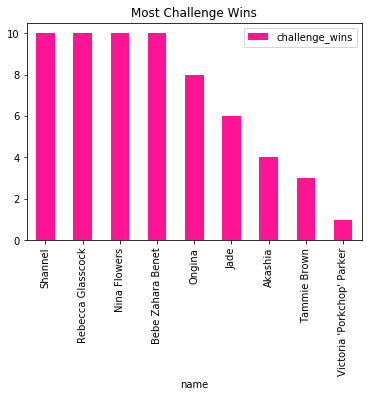

In [114]:
get_challenges().to_sql('challenges', drag_race_data_base, if_exists="replace")
challenge_wins_df = pd.read_sql("SELECT id, name, count(won) AS challenge_wins FROM challenges GROUP BY name ORDER BY challenge_wins DESC LIMIT 10", drag_race_data_base)

challenge_wins_df.plot.bar(y='challenge_wins', x="name", color="deeppink", title="Most Challenge Wins")